In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestRegressor

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


def rmse(y_test, preds):

    return np.sqrt(mean_squared_error(y_test, preds))

## EXPERIMENT - Random Forest vs eXtremeGradientBoosting

In this experiment we will not go through technical differences between Random Forest and XGBoost, we would like to run a quick test to try to do a comparison between those two algorithms on a chemical dataset. The reason behind this is, that the Random Forest is widely used in chemoinformatics and We would like to see, if using XGB may not bring some advantages. Both are ensemble algorithms - Random Forest based on the bagging idea (Tim Kan Ho 1995), while XGB (research project initially started by Tianqi Chen, the very first release of the library in 2014 https://xgboost.ai/) on gradient boosting. The initial idea behind XGB was to build a faster and better performing algorithm, and we will try if that is also true for a chemical type of data, where molecules are encoded by the Morgan fingerprint RDKit algorithm. It is not a rigorously performed experiment by any means, just a little test to have an idea of what the differences are. Each dataset may need a different treatment, but as the winner of the Kaggle challenge says: "When in doubt, just use XGBoost." (Owen Zhang)
(https://dataaspirant.com/xgboost-algorithm/#:~:text=The%20popularity%20of%20using%20the%20XGBoost%20algorithm%20intensively,Zhang%20said%2C%20%E2%80%9CWhen%20in%20doubt%2C%20just%20use%20XGBoost.%E2%80%9D)

Picture from the web article: https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

![image info](https://miro.medium.com/max/1400/1*U72CpSTnJ-XTjCisJqCqLg.jpeg)



## Data

The dataset is 7230 datapoints big<br>
Features: Molecules in SMILES notation<br>
Target: Measured pIC50 values

In [3]:
df = pd.read_csv('data/VEGF2_ML_ready.csv')
print(df.shape)
df.head()

(7230, 3)


,smiles,label,ds
0,CCCOCc1ccc2c(c1)c1c3c(c4c(c1n2CCCO)Cc1ccccc1-4...,8,7.89
1,O=C(Nc1ccc(Nc2ncnc3sc4c(c23)CCCC4)cc1)Nc1ccc(C...,9,6.70
2,COc1cc2c(Nc3cccc4occc34)ncnc2cc1OCCCN1CCOCC1,8,6.60
3,CCc1cccc(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)cc2)c1,9,8.22
4,COc1cccc(C(=O)CN2CCN(c3nnc(-c4ccccc4)c4ccccc34...,9,5.47


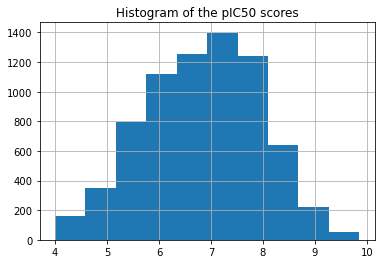

In [4]:
df.ds.hist()
plt.title('Histogram of the pIC50 scores')
plt.show()

In [5]:
mols = [Chem.MolFromSmiles(smi) for smi in df.smiles]
mfps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, 2048) for m in mols]

In [6]:
X = mfps
y = df.ds

## XGBoost

|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  2        | -0.4783   |  0.7466   |  17.8     |  9.93     |  506.1    |  0.8478   |
|  14       | -0.4765   |  0.7133   |  15.85    |  6.233    |  209.4    |  0.9222   |
|  20       | -0.4684   |  0.7271   |  14.15    |  7.361    |  209.9    |  0.9465   |


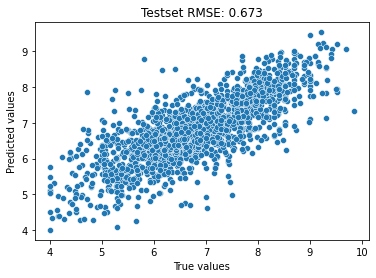

CPU times: total: 10min 27s
Wall time: 2h 43min 17s


In [14]:
%%time
xgb = optimized_reg(X, y)

## Random Forest

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  2        | -0.5927   |  14.94    |  8.115    |  481.8    |
|  4        | -0.5499   |  17.93    |  6.69     |  247.2    |
|  7        | -0.5431   |  18.8     |  8.878    |  253.8    |
|  9        | -0.5237   |  20.0     |  7.371    |  473.3    |
|  13       | -0.5176   |  20.0     |  2.0      |  453.8    |
|  14       | -0.5176   |  20.0     |  2.0      |  442.9    |


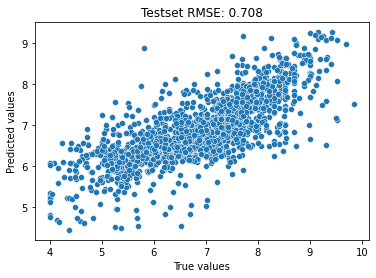

CPU times: total: 11min
Wall time: 4h 1min 29s


In [25]:
%%time
rf = optimized_reg(X, y)

## XGB vs RF cv

Text(0.5, 1.0, 'optimized RF vs XGB models\nMSE cv=5')

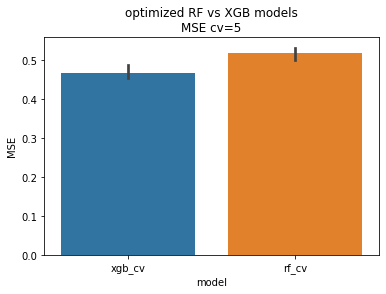

In [35]:
df_cv_res = pd.DataFrame({'xgb_cv': np.abs(xgb.cv_train_results),
                         'rf_cv': np.abs(rf.cv_train_results),})

df_melt = pd.melt(df_cv_res, value_name="MSE", var_name='model')
sns.barplot(data=df_melt, x='model', y='MSE')
plt.title('optimized RF vs XGB models\nMSE cv=5')

In [44]:
pd.DataFrame({'MSE mean':df_cv_res.mean(),
             'MSE std': df_cv_res.mean()}).T

,xgb_cv,rf_cv
MSE mean,0.468388,0.517559
MSE std,0.468388,0.517559


#### Testset results

In [45]:
testset_mse_res = pd.DataFrame({'MSE XGB': [mean_squared_error(xgb.preds, xgb.test_y)],
                                'MSE RF': [mean_squared_error(rf.preds, rf.test_y)]})
testset_mse_res

,MSE XGB,MSE RF
0,0.453292,0.501872


## Conclusion

We have indeed shown, that on this particular dataset, XGB outperforms RF both regarding the computational time and the model performance.<br>

#### Computational Time:
    XGB: CPU times: total: 10min 27s
         Wall time: 2h 43min 17s

    RF: CPU times: total: 11min
        Wall time: 4h 1min 29s


#### Parameters of the metrics are as follows:
    models were optimized by Bayesian Optimization 
    train test set split: 75 vs 25
    5 time cv on the trainset
    kFold: shuffle=True, random_state=0
     
#### Computed on:<br>
    Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz   1.80 GHz
    RAM 8,00 GB


### HELPERS

In [24]:
class optimized_reg:
    '''
    The class holds all the information about an optimized regressor
    for the selected task and it's relevant data.
    '''
    
    def __init__(self, X, y, scaling=True):
        self.kf = KFold(n_splits=5, shuffle=True, random_state=0)
        self.train_X, self.test_X, self.train_y, self.test_y = train_test_split(X, y, 
                                                                                test_size=0.25, 
                                                                                random_state=0)        
        if scaling:
            self.scaler = MinMaxScaler()
            self.train_X = self.scaler.fit_transform(self.train_X)
            self.test_X = self.scaler.transform(self.test_X)
        
        self.model, self.hp = self.get_optimized_clf()
        self.preds = self.predict()
        self.plot = self.report_results()
        self.cv_train_results = cross_val_score(self.model, self.train_X, self.train_y, 
                                          scoring='neg_mean_squared_error', 
                                          cv=self.kf, n_jobs=-1)
        
    def reg_crossval(self, min_samples_split, n_estimators, max_depth):
        reg = RandomForestRegressor(min_samples_split=min_samples_split.astype(int),
                                    n_estimators=n_estimators.astype(int),
                                    max_depth=max_depth.astype(int),                         
                                    random_state=0)     
        mean_cv_score = cross_val_score(reg, self.train_X, self.train_y, scoring='neg_mean_squared_error', 
                                    cv=self.kf, n_jobs=-1).mean()

        return mean_cv_score

    def get_optimized_clf(self,):    
        optimizer = BayesianOptimization(f=self.reg_crossval, 
                                         pbounds={'min_samples_split' : [2, 10],
                                                    'n_estimators' : [100, 600],
                                                    'max_depth': [3, 20]}, 
                                                     verbose=1)

        optimizer.maximize(init_points=5, n_iter=15)
        hp = optimizer.max['params']
        hp.update({'min_samples_split': int(optimizer.max['params']['min_samples_split']),
                    'n_estimators':int(optimizer.max['params']['n_estimators']),
                    'max_depth':int(optimizer.max['params']['max_depth'])})
        model = RandomForestRegressor(**hp, random_state=0)
        model.fit(self.train_X, self.train_y)
        
        return model, hp
        
    def predict(self,):
        preds = self.model.predict(self.test_X)
        
        return preds

    def report_results(self,):     
        g = sns.scatterplot(x=self.test_y, y=self.preds)
        plt.title('Testset RMSE: %.3f' % (rmse(self.test_y, self.preds)))
        plt.xlabel('True values')
        plt.ylabel('Predicted values')
        plt.show()

        return g